In [330]:
#read in data from csv file
#using Pkg
#Pkg.add("CSV")
using CSV
# CSV File with oxyegn adsoprtion energies, columns are crystal number, crystal chemical formula
# adsorption site and oxyegn adsoprtion energies
#Oads=CSV.File("/Users/yusuliu/Downloads/18.337_2018/project/3colOads.csv") 
Oads=CSV.File("3colOads.csv") 

CSV.File("3colOads.csv", rows=1000):
Tables.Schema:
 :Count  Union{Missing, Int64}  
 :Name   Union{Missing, String} 
 :Site   Union{Missing, String} 
 :E      Union{Missing, Float64}

In [332]:
# CSV File with data from the periodic table
# columns are element name, A site or B site element in a perovskite, atomic number, period
# covalent radius, d-electron count, electronegativity, most common oxidation state
# polarizability, ionization energy
PD=CSV.File("PeriodicData.csv")

CSV.File("PeriodicData.csv", rows=28):
Tables.Schema:
 :Element          Union{Missing, String} 
 :AorB             Union{Missing, String} 
 :Z                Union{Missing, Int64}  
 :period           Union{Missing, Int64}  
 :covalent_radius  Union{Missing, Float64}
 :d_elect          Union{Missing, Int64}  
 :Eneg             Union{Missing, Float64}
 :Ox               Union{Missing, Float64}
 :Pol              Union{Missing, Float64}
 :IE               Union{Missing, Float64}

In [334]:
#Make dictionaries from Periodic date
AorB =Dict{String,String}()
Z=Dict{String,Int64}()
period=Dict{String,Int64}()
radius=Dict{String,Float64}()
d_elect=Dict{String,Int64}()
Eneg=Dict{String,Float64}()
Ox=Dict{String,Float64}()
Pol=Dict{String,Float64}()
IE=Dict{String,Float64}()

for row in PD
    AorB[row.Element]=row.AorB
    Z[row.Element]=row.Z
    period[row.Element]=row.period
    radius[row.Element]=row.covalent_radius
    d_elect[row.Element]=row.d_elect
    Eneg[row.Element]=row.Eneg
    Ox[row.Element]=row.Ox
    Pol[row.Element]=row.Pol
    IE[row.Element]=row.IE
end



In [335]:
# functions to parse a chemical formula 

# get captical letters which are the indicator for the start of a new element
function getcaps(string)
    pos=[]
    for (index, letter) in enumerate(string)
        if (letter==uppercase(letter))
            append!(pos,index)
        end
    end
    return pos
end

# determine if an element is A or B site
function getelements(string)
    set=getcaps(string)
    j=length(set)
    element_list_A=String[]
    element_list_B=String[]
    for i in 1:j-2
        Astart=set[i]
        Bstart=set[i+1]
        new_el=string[Astart:(Bstart-1)]
        if AorB[new_el]=="A"
            push!(element_list_A, String(new_el))
        elseif AorB[new_el]=="B"
            push!(element_list_B, String(new_el))
        end 
    end
    return element_list_A, element_list_B
end

# function to vectorize each element
function makevec(element)
    vec=zeros(8)
    vec[1]=Z[element]
    vec[2]=period[element]
    vec[3]=radius[element]
    vec[4]=d_elect[element]
    vec[5]=Eneg[element]
    vec[6]=Ox[element]
    vec[7]=Pol[element]
    vec[8]=IE[element]
    return vec
end




makevec (generic function with 1 method)

In [336]:
# make input array, 24 attributes per cyrstal, 1000 crystals
using Statistics
input_mat=zeros(24,1000)
for i=1:1003
    for row in Oads
        if (row.Count)==i
            set_A,set_B=getelements(row.Name)
            size_A=length(set_A)
            size_B=length(set_B)
            vecsA=[]
            vecsB=[]
            for i in 1:size_A
                newvec=makevec((set_A[i]))
                push!(vecsA,newvec)
            end
            for i in 1:size_B
                newvec=makevec((set_B[i]))
                push!(vecsB,newvec)
            end
            input_mat[1:8,i]=mean(vecsA)
            input_mat[9:16,i]=mean(vecsB)
            input_mat[17:24,i]=makevec(row.Site)
        end
    end
end
display("text/plain",input_mat) 

24×1000 Array{Float64,2}:
 59.5    60.0     61.0    61.0    …  60.0     61.0    60.0     60.0   
  6.0     6.0      6.0     6.0        6.0      6.0     6.0      6.0   
  1.915   1.8      1.63    1.63       1.8      1.63    1.8      1.8   
  0.0     0.5      0.0     0.0        0.5      0.0     0.5      0.5   
  1.045   1.045    1.13    1.13       1.045    1.13    1.045    1.045 
  2.25    2.5      3.0     3.0    …   2.5      3.0     2.5      2.5   
 33.7    31.6     30.1    30.1       31.6     30.1    31.6     31.6   
  5.438   5.6755   5.554   5.554      5.6755   5.554   5.6755   5.6755
 41.0    44.0     25.0    44.0       40.0     29.0    25.0     46.0   
  5.0     5.0      4.0     5.0        5.0      4.0     4.0      5.0   
  1.34    1.25     1.17    1.25   …   1.25     1.17    1.17     1.28  
  3.0     6.0      5.0     6.0        2.0      9.0     5.0      8.0   
  1.6     2.2      1.55    2.2        1.33     1.9     1.55     2.2   
  4.0     4.6      4.4     4.6        4.0      1.5 

In [338]:
# make target vector: oxygen adsorption energies
target=Float64[]
for row in Oads
    append!(target,row.E)
end

y=zeros(1,1000)
for i in 1:1000
    y[1,i]=target[i]
end
display("text/plain",y)  

1×1000 Array{Float64,2}:
 -20.9685  -18.3228  -16.6349  …  2.60126  7.46994  7.78974  8.87288

In [339]:
# normalize x input array

using Statistics, Random
x=copy(input_mat)
x_norm=copy(x)
for i=1:size(x,1)
    m=mean(x[i,:])
    stdev=std(x[i,:])
    for j=1:size(x,2)
        x_norm[i,j]=(x[i,j]-m)/stdev
    end
end


In [340]:
# randomize and seperate into 700 training points and 300 test points

index=randperm(Random.seed!(1),size(x,2))
xtrn=x_norm[:,index[1:700]]
xtst=x_norm[:,index[701:end]]
ytrn=y[:,index[1:700]]
ytst=y[:,index[701:end]]

1×300 Array{Float64,2}:
 -2.80295  -5.24203  -5.29491  -7.87468  …  -4.73293  -3.69288  -9.0944

In [341]:
# make weight matrix
using Pkg
#Pkg.add("Distributions")
using Distributions
d=Normal()
weights=rand(d,24)*0.1
w=(weights,[0.0])

([0.0635889, -0.185359, 0.0810713, 0.0158052, 0.0580127, -0.011097, -0.0968496, -0.0393294, -0.0243981, -0.0775562  …  0.114181, -0.165903, -0.12511, -0.181291, 0.00803023, 0.0067685, -0.00588284, 0.0341452, 0.0741828, -0.202932], [0.0])

In [342]:
# function to take in weight and input, gives output prediction vector
function predict_lr(w_mat, att_mat) # takes weight matrix and attributes matrix as arguments
    v_out=zeros(size(att_mat,2)) # initialize output matrix
    v_out=w_mat[1]'*att_mat.+w_mat[2]
    return v_out
end


predict_lr (generic function with 1 method)

In [343]:
# function to calculate mean absolute error
function MAE_loss(w,x,y) # takes in weight, input matrix and ground truth
    ypred=predict_lr(w,x) 
    summ=sum(abs(ypred[i]-y[i]) for i=1:size(y,2))
    J=summ/(size(y,2))
    return J
end

MAE_loss (generic function with 1 method)

In [344]:
# training function using autograd and knet
#Pkg.add("AutoGrad")
#Pkg.add("Knet")
using AutoGrad, Knet

function train(ww,lr, epochs)   
    lossgradient=grad(MAE_loss)
    println((0, :trnloss, MAE_loss(ww,xtrn,ytrn), :tstloss, MAE_loss(ww,xtst,ytst)))
    for epoch=1:epochs        
        dw=lossgradient(ww, xtrn, ytrn) 
      
        for i in 1:length(ww)   
            for j in 1:length(ww[i])
                ww[i][j] -=lr*dw[i][j]
            end
        end 
        println((epoch, :trnloss, MAE_loss(ww,xtrn,ytrn), :tstloss, MAE_loss(ww,xtst,ytst)))
    end
    return ww
end



train (generic function with 1 method)

In [346]:
# 0.27 learning rate, 200 epochs
d=Normal()
weights=rand(d,24)*0.1
w=(weights,[0.0])
train(w,0.27,200)
println(w)

(0, :trnloss, 5.812201778528555, :tstloss, 5.783835376161)
(1, :trnloss, 5.548019689315449, :tstloss, 5.525624505210485)
(2, :trnloss, 5.285564574203059, :tstloss, 5.267626754794884)
(3, :trnloss, 5.025705015126596, :tstloss, 5.011697007088098)
(4, :trnloss, 4.766843824287708, :tstloss, 4.756326755896198)
(5, :trnloss, 4.5079826334488295, :tstloss, 4.5009565047043)
(6, :trnloss, 4.249121442609955, :tstloss, 4.245586253512402)
(7, :trnloss, 3.990260251771067, :tstloss, 3.9910634523070834)
(8, :trnloss, 3.7334727562295313, :tstloss, 3.7400313205768194)
(9, :trnloss, 3.4856369457724354, :tstloss, 3.496170285259635)
(10, :trnloss, 3.246019854309629, :tstloss, 3.2605256790940933)
(11, :trnloss, 3.01747829523752, :tstloss, 3.0315152785492496)
(12, :trnloss, 2.790565437978286, :tstloss, 2.803136889201372)
(13, :trnloss, 2.566320729814648, :tstloss, 2.5767744369662964)
(14, :trnloss, 2.3475822020259454, :tstloss, 2.351953680139021)
(15, :trnloss, 2.134820663170838, :tstloss, 2.1329710061845297

(127, :trnloss, 0.9003310202749385, :tstloss, 0.9280289124367834)
(128, :trnloss, 0.9125232360653824, :tstloss, 0.9342835461049721)
(129, :trnloss, 0.8990769318904618, :tstloss, 0.9264635285795286)
(130, :trnloss, 0.9052974552095293, :tstloss, 0.9270230081898849)
(131, :trnloss, 0.8956290956347494, :tstloss, 0.9221462142786042)
(132, :trnloss, 0.9018343158116212, :tstloss, 0.9235526724687908)
(133, :trnloss, 0.8948713167851606, :tstloss, 0.9203400838725181)
(134, :trnloss, 0.9033117668783812, :tstloss, 0.9253848422333224)
(135, :trnloss, 0.896011341890243, :tstloss, 0.9223055926932253)
(136, :trnloss, 0.9087485227288742, :tstloss, 0.930488052859445)
(137, :trnloss, 0.8983520636741769, :tstloss, 0.9254762722394543)
(138, :trnloss, 0.9048187722726365, :tstloss, 0.9265497605029183)
(139, :trnloss, 0.8993454984721067, :tstloss, 0.9285673150970604)
(140, :trnloss, 0.906627995826929, :tstloss, 0.9289159798498976)
(141, :trnloss, 0.9012111593541248, :tstloss, 0.9301330598422997)
(142, :trnlos

In [347]:
# analyze performance of test set
# first look at by A and B numbers
test_set=index[701:end]
#retrieve formula from Oads table, categorize into # of As and Bs
AB=Int64[]
A2B=Int64[]
AB2=Int64[]
A2B2=Int64[]
for i in test_set
    for row in Oads
        if (row.Count)==i
            set_A,set_B=getelements(row.Name)
            size_A=length(set_A)
            size_B=length(set_B)
            if size_A==1 
                if size_B==1
                    push!(AB,i)
                elseif size_B==2
                    push!(AB2,i)
                end
            elseif size_A==2
                if size_B==1
                    push!(A2B,i)
                elseif size_B==2
                    push!(A2B2,i)
                end
            end
        end
    end
end


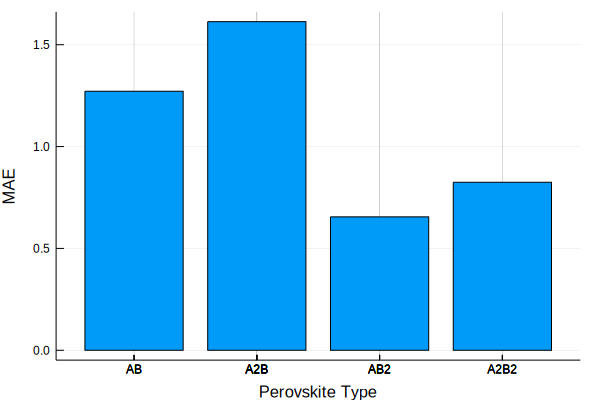

In [348]:
#Evaluate performance of each category by # of A sites and # of B sites
loss_AB=[]
for i in AB
    loss=abs((w[1]'*x_norm[:,i].+w[2])[1]-y[i])
    push!(loss_AB,loss)
end
MAE_AB=mean(loss_AB)

loss_A2B=[]
for i in A2B
    loss=abs((w[1]'*x_norm[:,i].+w[2])[1]-y[i])
    push!(loss_A2B,loss)
end
MAE_A2B=mean(loss_A2B)

loss_A2B2=[]
for i in A2B2
    loss=abs((w[1]'*x_norm[:,i].+w[2])[1]-y[i])
    push!(loss_A2B2,loss)
end
MAE_A2B2=mean(loss_A2B2)

loss_AB2=[]
for i in AB2
    loss=abs((w[1]'*x_norm[:,i].+w[2])[1]-y[i])
    push!(loss_AB2,loss)
end
MAE_AB2=mean(loss_AB2)

using Plots
x_dat=["AB", "A2B", "AB2", "A2B2"]
y_dat=[MAE_AB, MAE_A2B, MAE_AB2,MAE_A2B2]
plot(x_dat,y_dat,seriestype=:bar,xlabel = "Perovskite Type",ylabel = "MAE",legend=:none)



In [351]:
#Evaluate performance of each category by elements

set_el=String[]
for row in PD
    push!(set_el,row.Element)    
end
el_matt=zeros(length(set_el),1000)
el_dict=Dict{String,Int64}()
for i in 1:28
    el_dict[set_el[i]]=i
end


In [352]:

# el_matt: row number is the dict value of each element, if entry=1, then entry 
# has that element
# for example, row.Count=1, (22,1)=1 because it has Eu
for i in test_set
    for row in Oads
        if (row.Count)==i
            set_A,set_B=getelements(row.Name)
            bigset=vcat(set_A,set_B)
            for el in set_el
                if el in bigset
                    el_matt[el_dict[el],i]=1
                end
            end
        end
    end
end

#collect all non-zero entries
el_vec=[]
count_1=[]
dic_rev=Dict(value => key for (key, value) in el_dict)
# get average MAE vector by elements
for i in 1:28
    count=[]
    for j in 1:1000
        if el_matt[i,j]==1.0
            loss=abs((w[1]'*x_norm[:,j].+w[2])[1]-y[j])
            push!(count,loss)
        end
    end
    push!(el_vec,mean(count))
end
el_vec

28-element Array{Any,1}:
 0.8254359950908214 
 0.5594722617440011 
 0.576613170208411  
 1.051258664451097  
 0.42115692480098776
 0.6553206058051882 
 0.7676780026758735 
 0.7855559945947036 
 1.6838770686007407 
 1.3971481474820888 
 0.6493086480146583 
 0.4563552533949525 
 0.7091403996409344 
 ⋮                  
 4.217212138646781  
 0.8106414651405175 
 1.888900905238512  
 0.6969945667286961 
 0.674820703488499  
 2.3567393121902525 
 3.8846422079000016 
 0.8048168819095773 
 2.4084748767324684 
 1.4870664461443481 
 0.7387288585587733 
 0.9575636234901876 

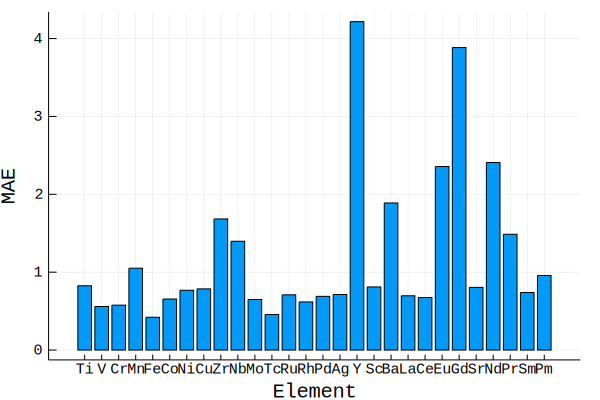

In [353]:
using Plots
x_dat_el=String[]
for i in 1:28
   
    element=dic_rev[i]
    push!(x_dat_el,element)
end
y_dat_el=el_vec
plot(x_dat_el,y_dat_el,seriestype=:bar,xlabel = "Element",ylabel = "MAE",legend=:none, xticks = :all,xtickfont = font(8, "Courier"))

